In [282]:
#surpress warnings
import warnings
warnings.simplefilter("ignore")
import csv

In [283]:
#Importing libraries:
%matplotlib inline
import nltk
from sklearn import metrics
import pandas as pd
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [284]:
training_set = pd.read_csv("train_covid.csv", sep=',')

In [285]:
training_set

,ID,title,text,label,X1,X2
0,1,US and UK have selected PM Modi to lead a coro...,18 nations including the United States and the...,FAKE,NaN,NaN
1,2,Thorough hand-washing with an ordinary soap is...,"Soap and water alone, when used as per the WHO...",REAL,NaN,NaN
2,3,Places most affected by coronavirus situated o...,Places most affected by coronavirus situated o...,FAKE,NaN,NaN
3,4,More immunity in Indian genes,Our bodies have one of the toughest immune sys...,FAKE,NaN,NaN
4,5,Vitamin C and lemon-infused hot water protect ...,The novel coronavirus is the result of a gene ...,FAKE,NaN,NaN
...,...,...,...,...,...,...
69,70,Are there roadblocks in India's fight against ...,Has the Tamil Nadu chief secretary let the cat...,REAL,NaN,NaN
70,71,How the 21-day lockdown can be a turning point...,As the world struggles with the coronavirus pa...,REAL,NaN,NaN
71,72,"No evidence of community transmission yet, rep...",The government on Friday once again reiterated...,REAL,NaN,NaN
72,73,India home quarantine families face discrimina...,India has quarantined tens of thousands of peo...,REAL,NaN,NaN


In [286]:
training_set[(training_set.X1.isnull()!=True & (training_set.X2.isnull()==True))].index

Int64Index([], dtype='int64')

In [287]:
training_set[training_set.X2.isnull()!=True].index

Int64Index([], dtype='int64')

In [288]:
training_set = training_set.drop("X1", axis=1)
training_set = training_set.drop("X2", axis=1)

In [289]:
training_set = training_set[(training_set.label == 'FAKE') | (training_set.label == 'REAL')]

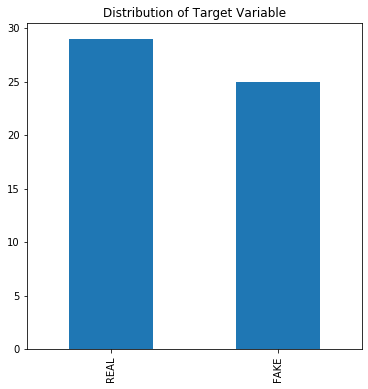

In [290]:
training_set['label'].value_counts().plot(kind='bar', title="Distribution of Target Variable", figsize=(6,6))

In [291]:
training_set_labels = training_set.label 
training_set_data = training_set.drop("label", axis = 1)
training_set_data = training_set_data.drop("ID", axis = 1)

In [292]:
training_set_data["full_text"] = training_set_data["title"].map(str) + " " + training_set_data["text"]
training_data = training_set_data["full_text"]

Text(0.5, 1.0, 'Title')

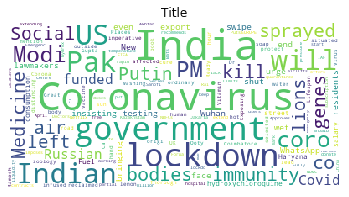

In [293]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=150,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(training_data))
plt.imshow(wordcloud)
plt.rcParams["figure.figsize"] = (16,17)
plt.axis('off')
plt.title("Title")

In [294]:
training_labels = training_set_labels.tolist()

In [295]:
training_labels

['FAKE',
 'REAL',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'REAL',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'FAKE',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'FAKE',
 'REAL',
 'REAL',
 'REAL',
 'FAKE',
 'REAL',
 'REAL',
 'REAL',
 'FAKE',
 'FAKE',
 'REAL',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'FAKE',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'REAL',
 'REAL']

In [296]:
labels = [1 if x =='FAKE' else 0 for x in training_labels]

In [297]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_list = stopwords.words('english')
stemmer = PorterStemmer()
all_tokens_lower = [t.lower() for t in training_data]
tokens_normalised = [stemmer.stem(t) for t in all_tokens_lower
                                     if t not in stop_list]

In [298]:
X_train, X_test, y_train, y_test = train_test_split(tokens_normalised, labels,test_size = 0.3, random_state = 42 )

In [299]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [300]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words = "english")), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])
parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3)], #test up to 3 n-grams
              'tfidf__use_idf': (True, False), 
              'tfidf__norm': ('l1', 'l2'), 
              'tfidf__sublinear_tf': (True, False), 
              'clf__alpha': (1e-2, 1e-3), 
              'clf__fit_prior':(True, False) }

In [301]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)

In [302]:
model = gs_clf.fit(X_train, y_train)

In [303]:
model.best_params_

{'clf__alpha': 0.001,
 'clf__fit_prior': True,
 'tfidf__norm': 'l1',
 'tfidf__sublinear_tf': True,
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 1)}

In [304]:
predicted = model.predict(X_test)

In [305]:
np.mean(predicted == y_test)

0.6470588235294118

In [318]:
testing_set = pd.read_csv("test.csv", sep=',')

In [319]:
testing_set_data = testing_set.drop("ID", axis = 1)

In [320]:
testing_set_data["full_text"] = testing_set_data["title"].map(str) + " " + testing_set_data["text"]
test_data = testing_set_data["full_text"]

In [321]:
stop_list = stopwords.words('english')
stemmer = PorterStemmer()
all_tokens_lower = [t.lower() for t in test_data]
tokens_normalised1 = [stemmer.stem(t) for t in all_tokens_lower
                                     if t not in stop_list]

In [322]:
final_trainX = np.asarray(tokens_normalised)
final_trainY = np.asarray(labels)
final_testX = np.asarray(tokens_normalised1)

In [323]:
modelfinal = gs_clf.fit(final_trainX, final_trainY)

In [324]:
modelfinal.best_params_

{'clf__alpha': 0.01,
 'clf__fit_prior': True,
 'tfidf__norm': 'l1',
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 1)}

In [325]:
predictedfinal = modelfinal.predict(final_testX)

In [326]:
results =  predictedfinal

In [327]:
results = ['FAKE' if x ==1 else 'REAL' for x in results]

In [328]:
results_final = pd.DataFrame(results, columns=['labels'])

In [329]:
results_final

,labels
0,FAKE
